In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions,plot_xgb_feature_importance


In [4]:
sheet = pd.read_excel('data_input_auto/山东柴油裂解差(多因子).xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')

sheet = sheet.rename(columns={'山东0#柴油净价-布伦特': '山东柴油裂解差'})

last_day = sheet['山东柴油裂解差'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,山东柴油裂解差,WTI连1合约价格（路透）20日环比,螺纹期货价格90日环比,柴油：社会库存：中国（周）：大样本4周环差,0#柴油价差（华东-山东）,DR007 - 7天逆回购利率/15DMA90日环差,柴油：独立炼厂：产量：中国（周）超季节性/3年,中国-美国10年期国债收益率差,USDCNH即期汇率,WTI连1合约价格（路透）,南华工业品指数20日环比,富时中国A50期货CN0W.SG收盘价5日环比/10DMA,西北地区LNG重卡与柴油重卡TCO持平时对应LNG价格-LNG：加气站：市场价：西安（日）,中国柴油库存可用天数同差,中国独立炼厂柴油库存3年百分位同差,Brent原油期货连1合约价格/路透
2025-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# 尝试多个可能的文件路径
file_paths1 = [
    os.path.expanduser("~/Desktop/X-BASE/宏观经济/eta/USDCNY即期汇率_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/宏观经济/eta/USDCNY即期汇率_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/宏观经济/eta/USDCNY即期汇率_合并数据.xlsx")
]

file_path1 = None
for path in file_paths1:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path1 = path
        break

if file_path1 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
    sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
    sheet1 = sheet1.drop(columns=['真实值'])
    sheet1 = sheet1.dropna()
    sheet1 = sheet1.sort_values('Date', ascending=True)
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet1.head()


,Date,预测值
19,2025-11-10,7.1252
18,2025-11-11,7.1325
17,2025-11-12,7.1325
16,2025-11-13,7.1383
15,2025-11-14,7.1384


In [6]:
# 尝试多个可能的文件路径
file_paths2 = [
    os.path.expanduser("~/Desktop/X-BASE/wti模型3.0/eta/wti_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/wti模型3.0/eta/wti_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/wti模型3.0/eta/wti_合并数据.xlsx")
]

file_path2 = None
for path in file_paths2:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path2 = path
        break

if file_path2 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet2 = pd.ExcelFile(file_path2).parse('Sheet1')
    sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
    sheet2 = sheet2.drop(columns=['wti原油期货价格'])
    sheet2 = sheet2.dropna()
    sheet2 = sheet2.sort_values('Date', ascending=True)
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet2.head()

,Date,WTI原油期货价格预测
19,2025-11-10,59.92
18,2025-11-11,60.89
17,2025-11-12,60.90
16,2025-11-13,60.89
15,2025-11-14,60.91


In [7]:
# 尝试多个可能的文件路径
file_paths3 = [
    os.path.expanduser("~/Desktop/X-BASE/宏观经济/eta/中国10年期国债收益率_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/宏观经济/eta/中国10年期国债收益率_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/宏观经济/eta/中国10年期国债收益率_合并数据.xlsx")
]

file_path3 = None
for path in file_paths3:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path3 = path
        break

if file_path3 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet3 = pd.ExcelFile(file_path3).parse('Sheet1')
    sheet3['Date'] = pd.to_datetime(sheet3['Date'], errors='coerce')
    sheet3 = sheet3.drop(columns=['实际值'])
    sheet3 = sheet3.dropna()
    sheet3 = sheet3.sort_values('Date', ascending=True)
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet3.head()

,Date,中国10年期国债收益率
19,2025-11-10,1.79054
18,2025-11-11,1.79104
17,2025-11-12,1.79203
16,2025-11-13,1.78291
15,2025-11-14,1.78786


In [8]:
# 尝试多个可能的文件路径
file_paths4 = [
    os.path.expanduser("~/Desktop/X-BASE/宏观经济/eta/10年期美国国债收益率_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/宏观经济/eta/10年期美国国债收益率_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/宏观经济/eta/10年期美国国债收益率_合并数据.xlsx")
]

file_path4 = None
for path in file_paths4:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path4 = path
        break

if file_path4 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet4 = pd.ExcelFile(file_path4).parse('Sheet1')
    sheet4['Date'] = pd.to_datetime(sheet4['Date'], errors='coerce')
    sheet4 = sheet4.drop(columns=['实际值'])
    sheet4 = sheet4.dropna()
    sheet4 = sheet4.sort_values('Date', ascending=True)
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet4.head()

,Date,10年期美国国债收益率
19,2025-11-10,4.14
18,2025-11-11,4.15
17,2025-11-12,4.14
16,2025-11-13,4.12
15,2025-11-14,4.11


In [9]:
# 尝试多个可能的文件路径
file_paths5 = [
    os.path.expanduser("~/Desktop/X-BASE/Wti模型3.0/eta/Brent原油价格_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/Wti模型3.0/eta/Brent原油价格_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/Wti模型3.0/eta/Brent原油价格_合并数据.xlsx")
]

file_path5 = None
for path5 in file_paths5:
    if os.path.isfile(path5):  # 确保是文件而不是目录
        file_path5 = path5
        break

if file_path5 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet5 = pd.ExcelFile(file_path5).parse('Sheet1')
    sheet5['Date'] = pd.to_datetime(sheet5['Date'], errors='coerce')
    sheet5 = sheet5.drop(columns=['布伦特原油期货价格'])
    sheet5 = sheet5.dropna()
    sheet5 = sheet5.sort_values('Date', ascending=True)
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet5.head()

,Date,Brent原油期货价格预测
20,2025-11-10,63.98
19,2025-11-11,64.92
18,2025-11-12,64.85
17,2025-11-13,64.98
16,2025-11-14,64.20


In [10]:
# 计算中美利差
sheet3['中国-美国利差'] = sheet3['中国10年期国债收益率'] - sheet4['10年期美国国债收益率']

In [11]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['USDCNH即期汇率'] = sheet_daily['USDCNH即期汇率'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', 'WTI原油期货价格预测']],
    on='Date',
    how='left'
)
sheet_daily['WTI连1合约价格（路透）'] = sheet_daily['WTI连1合约价格（路透）'].fillna(sheet_daily['WTI原油期货价格预测'])
sheet_daily = sheet_daily.drop(columns=['WTI原油期货价格预测'])

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet3[['Date', '中国-美国利差']],
    on='Date',
    how='left'
)
sheet_daily['中国-美国10年期国债收益率差'] = sheet_daily['中国-美国10年期国债收益率差'].fillna(sheet_daily['中国-美国利差'])
sheet_daily = sheet_daily.drop(columns=['中国-美国利差'])


sheet_daily = pd.merge(
    sheet_daily,
    sheet5[['Date', 'Brent原油期货价格预测']],
    on='Date',
    how='left'
)
sheet_daily['Brent原油期货连1合约价格/路透'] = sheet_daily['Brent原油期货连1合约价格/路透'].fillna(sheet_daily['Brent原油期货价格预测'])
sheet_daily = sheet_daily.drop(columns=['Brent原油期货价格预测'])

# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')

In [12]:
sheet.columns

Index(['山东柴油裂解差', 'WTI连1合约价格（路透）20日环比', '螺纹期货价格90日环比', '柴油：社会库存：中国（周）：大样本4周环差',
       '0#柴油价差（华东-山东）', 'DR007 - 7天逆回购利率/15DMA90日环差',
       '柴油：独立炼厂：产量：中国（周）超季节性/3年', '中国-美国10年期国债收益率差', 'USDCNH即期汇率',
       'WTI连1合约价格（路透）', '南华工业品指数20日环比', '富时中国A50期货CN0W.SG收盘价5日环比/10DMA',
       '西北地区LNG重卡与柴油重卡TCO持平时对应LNG价格-LNG：加气站：市场价：西安（日）', '中国柴油库存可用天数同差',
       '中国独立炼厂柴油库存3年百分位同差', 'Brent原油期货连1合约价格/路透'],
      dtype='object')

In [13]:
################################# 处理缺失值 #################################
fill_methods = {
'WTI连1合约价格（路透）20日环比':'interpolate', 
'螺纹期货价格90日环比':'interpolate', 
'柴油：社会库存：中国（周）：大样本4周环差':'interpolate',
'0#柴油价差（华东-山东）':'interpolate', 
'DR007 - 7天逆回购利率/15DMA90日环差':'interpolate',
'柴油：独立炼厂：产量：中国（周）超季节性/3年':'interpolate', 
'USDCNH即期汇率':'interpolate', 
'WTI连1合约价格（路透）':'interpolate', 
'中国-美国10年期国债收益率差':'interpolate',
'南华工业品指数20日环比':'interpolate', 
'富时中国A50期货CN0W.SG收盘价5日环比/10DMA':'interpolate',
'西北地区LNG重卡与柴油重卡TCO持平时对应LNG价格-LNG：加气站：市场价：西安（日）':'interpolate',
'中国柴油库存可用天数同差':'interpolate',
'中国独立炼厂柴油库存3年百分位同差':'interpolate',
'Brent原油期货连1合约价格/路透':'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, 'LME铜价'] = sheet.loc[:last_day, 'LME铜价'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['WTI连1-20日环比'] = (sheet['WTI连1合约价格（路透）'] - sheet['WTI连1合约价格（路透）'].shift(20)) / sheet['WTI连1合约价格（路透）'].shift(20)
sheet['柴油：社会库存：中国（周）：大样本4周环差_提前30天'] = sheet['柴油：社会库存：中国（周）：大样本4周环差'].shift(30)
sheet['螺纹期货价格90日环比_提前30天'] = sheet['螺纹期货价格90日环比'].shift(30)
sheet['0#柴油价差（华东-山东）_提前25天'] = sheet['0#柴油价差（华东-山东）'].shift(25)
sheet['南华工业品指数20日环比_提前30天'] = sheet['南华工业品指数20日环比'].shift(34)
sheet['富时中国A50期货CN0W.SG收盘价5日环比/10DMA_提前20天'] = sheet['富时中国A50期货CN0W.SG收盘价5日环比/10DMA'].shift(20)
sheet['DR007 - 7天逆回购利率/15DMA90日环差_提前25天'] = sheet['DR007 - 7天逆回购利率/15DMA90日环差'].shift(25)
sheet['柴油：独立炼厂：产量：中国（周）超季节性/3年_提前20天'] = sheet['柴油：独立炼厂：产量：中国（周）超季节性/3年'].shift(20)
sheet['西北地区LNG重卡与柴油重卡TCO持平时对应LNG价格-LNG：加气站：市场价：西安（日）_提前20天'] = sheet['西北地区LNG重卡与柴油重卡TCO持平时对应LNG价格-LNG：加气站：市场价：西安（日）'].shift(20)
sheet['中国柴油库存可用天数同差_提前20天'] = sheet['中国柴油库存可用天数同差'].shift(20)
sheet['中国独立炼厂柴油库存3年百分位同差_提前20天'] = sheet['中国独立炼厂柴油库存3年百分位同差'].shift(20)

sheet['柴油：独立炼厂：产量：中国（周）超季节性/3年_提前20天_逆序'] = reverse_column(sheet, '柴油：独立炼厂：产量：中国（周）超季节性/3年_提前20天')
sheet['USDCNH即期汇率_逆序'] = reverse_column(sheet, 'USDCNH即期汇率')
sheet['WTI连1-20日环比_逆序'] = reverse_column(sheet, 'WTI连1-20日环比')
sheet['Brent原油期货连1合约价格/路透_逆序'] = reverse_column(sheet, 'Brent原油期货连1合约价格/路透')

sheet['WTI连1-20日环比_逆序_提前1天'] = sheet['WTI连1-20日环比_逆序'].shift(1)
sheet['WTI连1-20日环比_逆序_提前2天'] = sheet['WTI连1-20日环比_逆序'].shift(2)
sheet['WTI连1-20日环比_逆序_提前3天'] = sheet['WTI连1-20日环比_逆序'].shift(3)
sheet['WTI连1-20日环比_逆序_提前4天'] = sheet['WTI连1-20日环比_逆序'].shift(4)
sheet['WTI连1-20日环比_逆序_提前5天'] = sheet['WTI连1-20日环比_逆序'].shift(5)
sheet['WTI连1-20日环比_逆序_提前6天'] = sheet['WTI连1-20日环比_逆序'].shift(6)
sheet['WTI连1-20日环比_逆序_提前7天'] = sheet['WTI连1-20日环比_逆序'].shift(7)

################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['山东柴油裂解差'].notna())
]
################################# 数据 读取-处理 结束 #################################

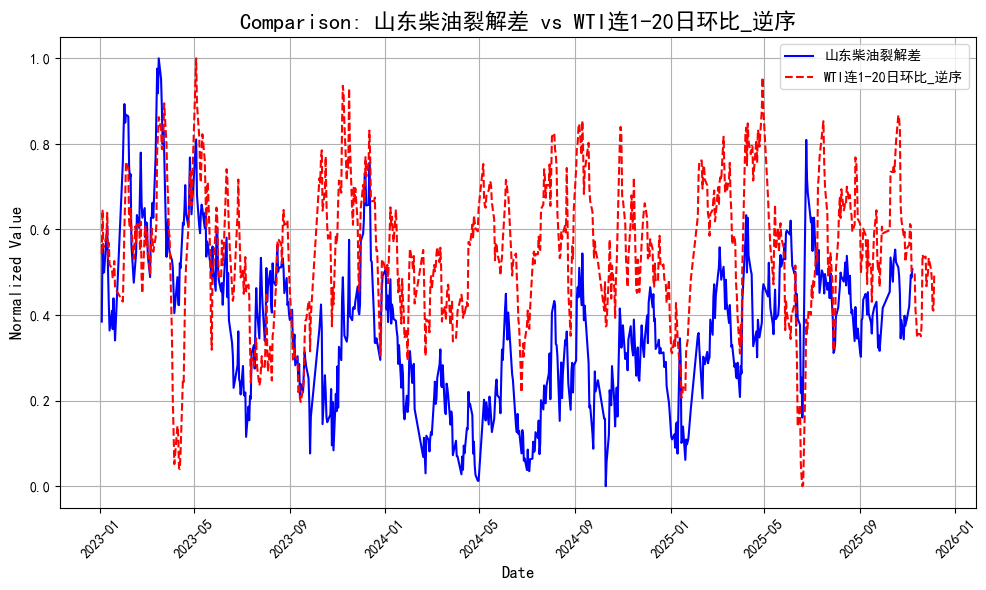

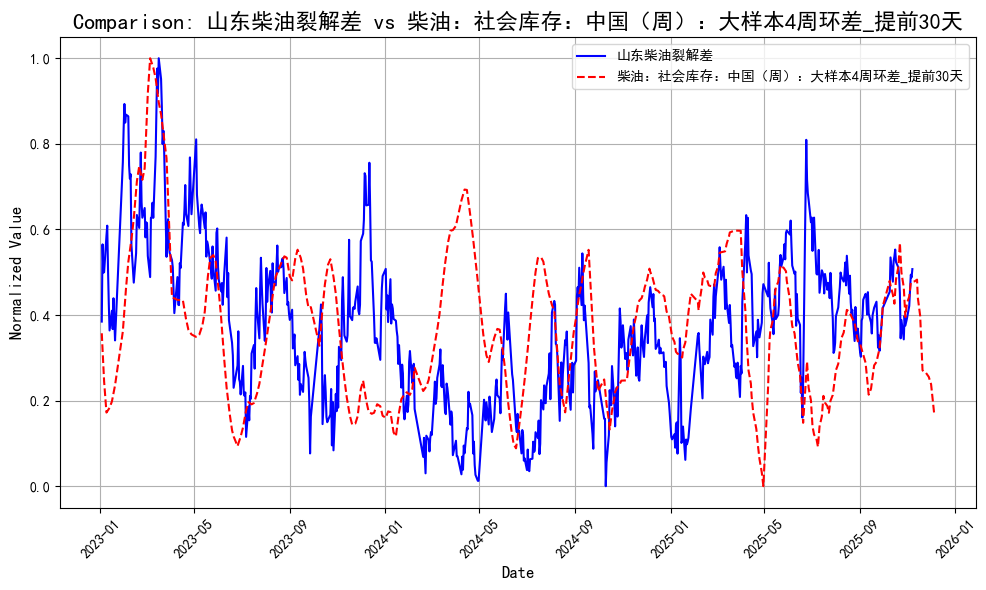

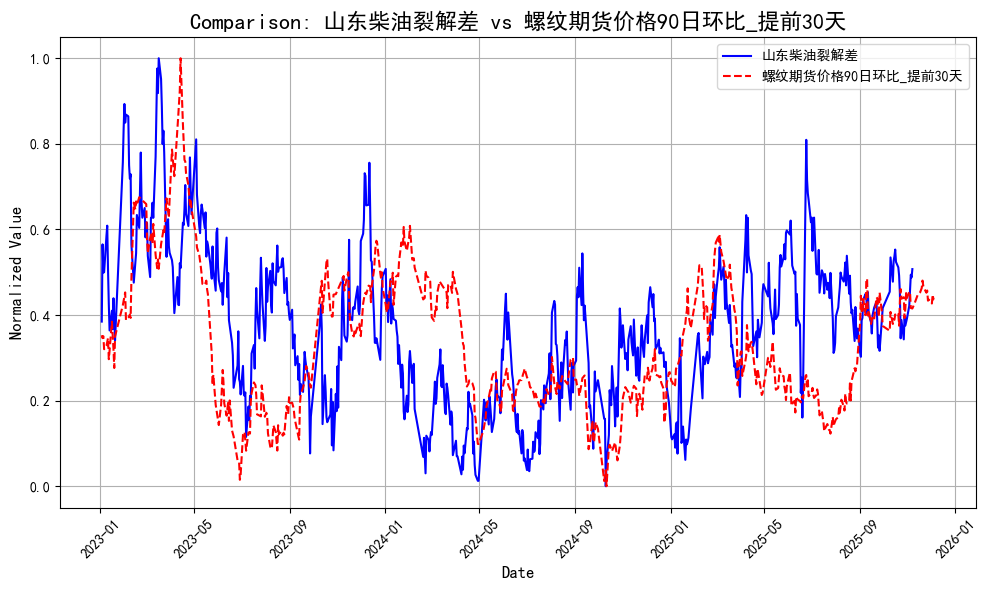

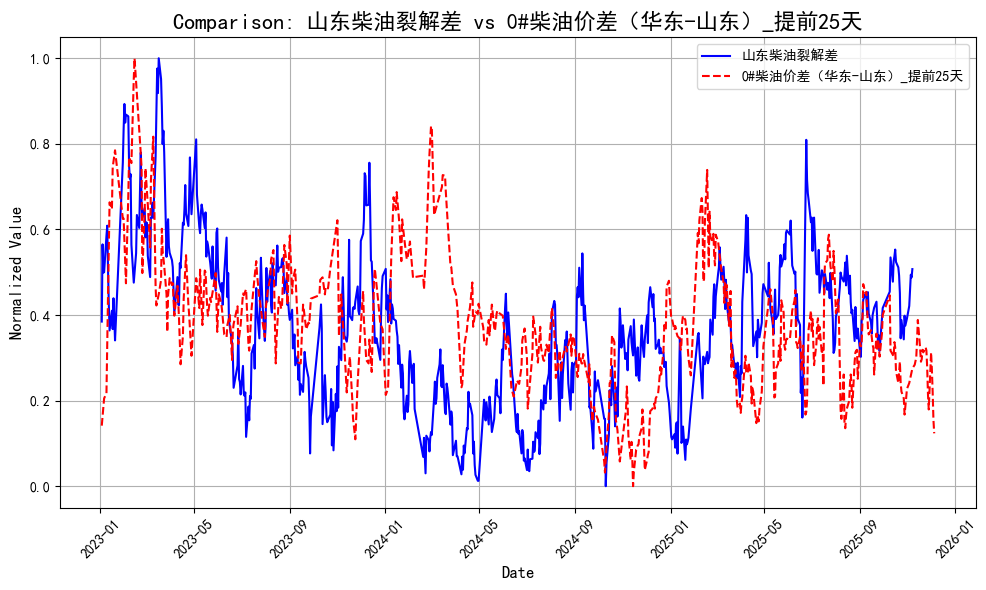

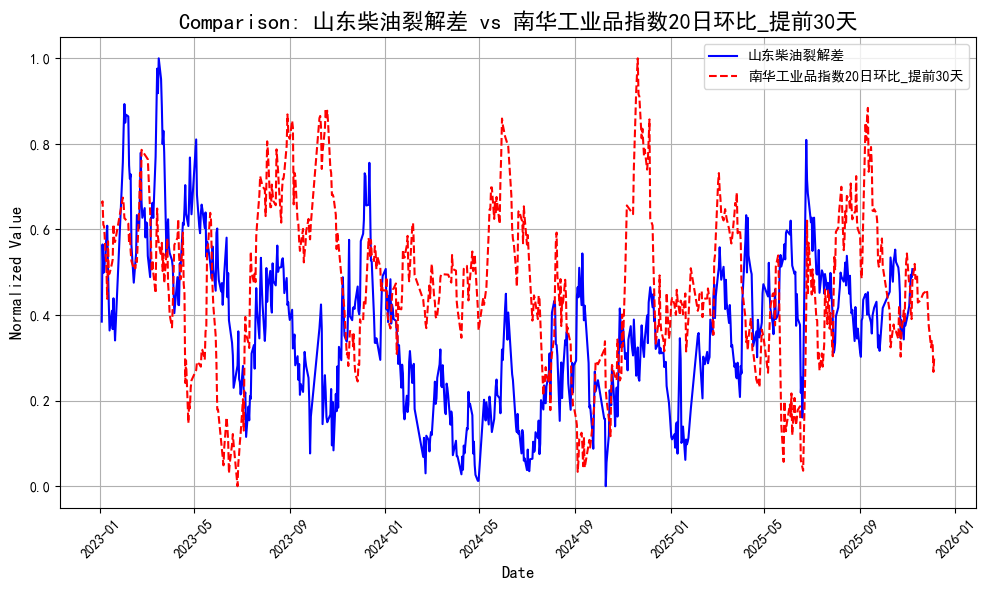

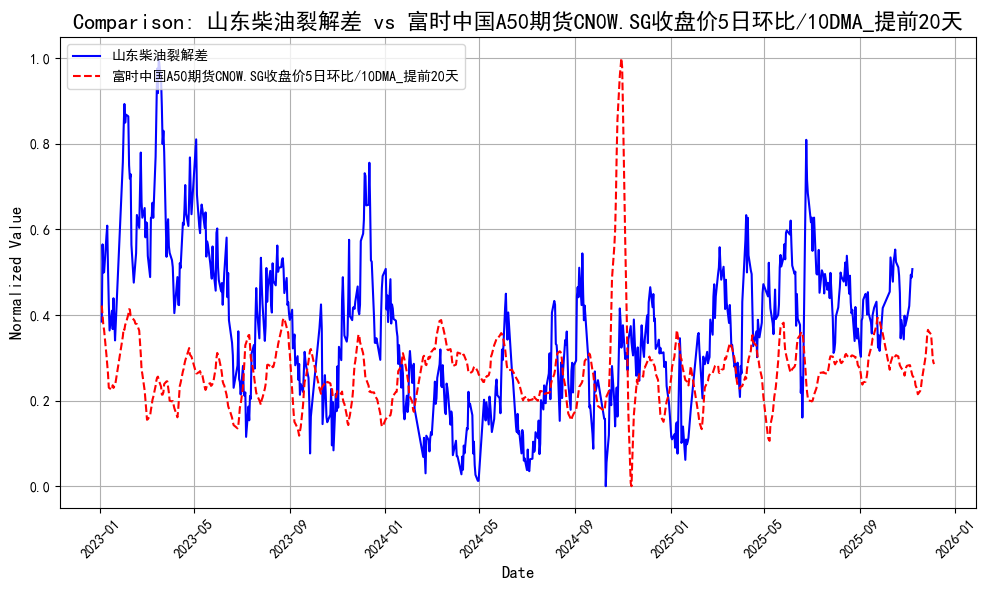

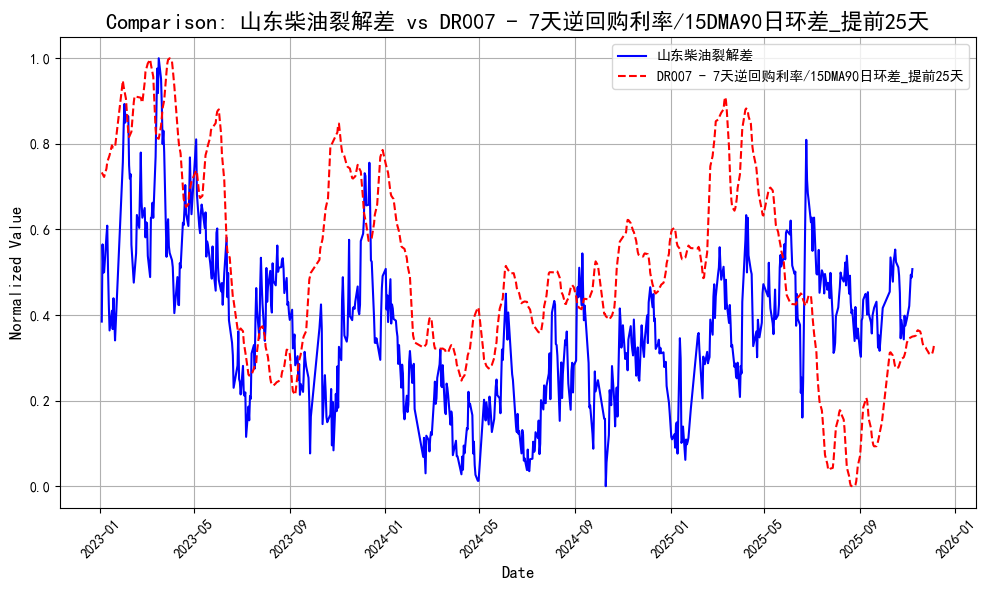

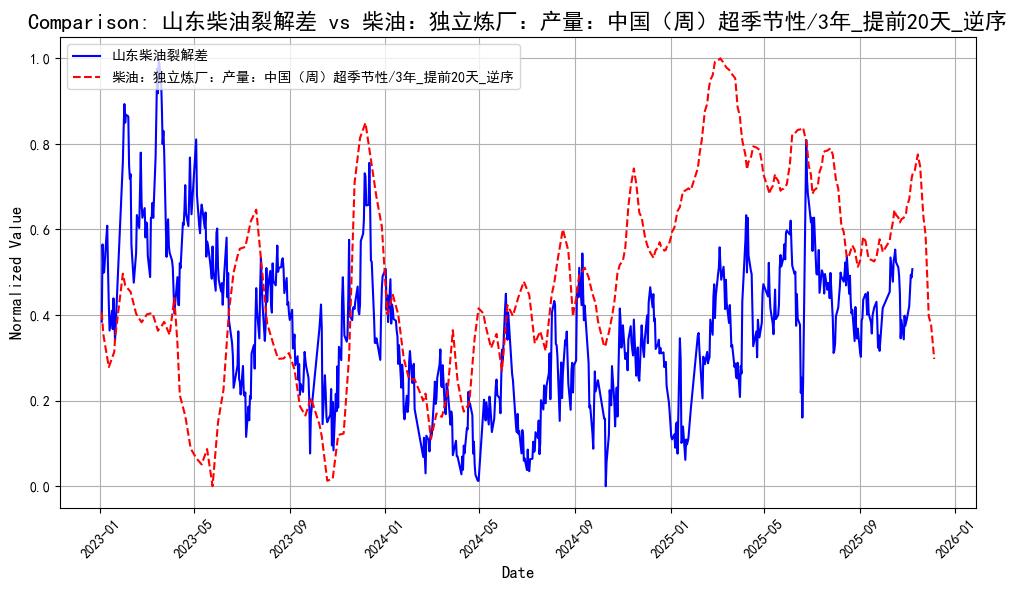

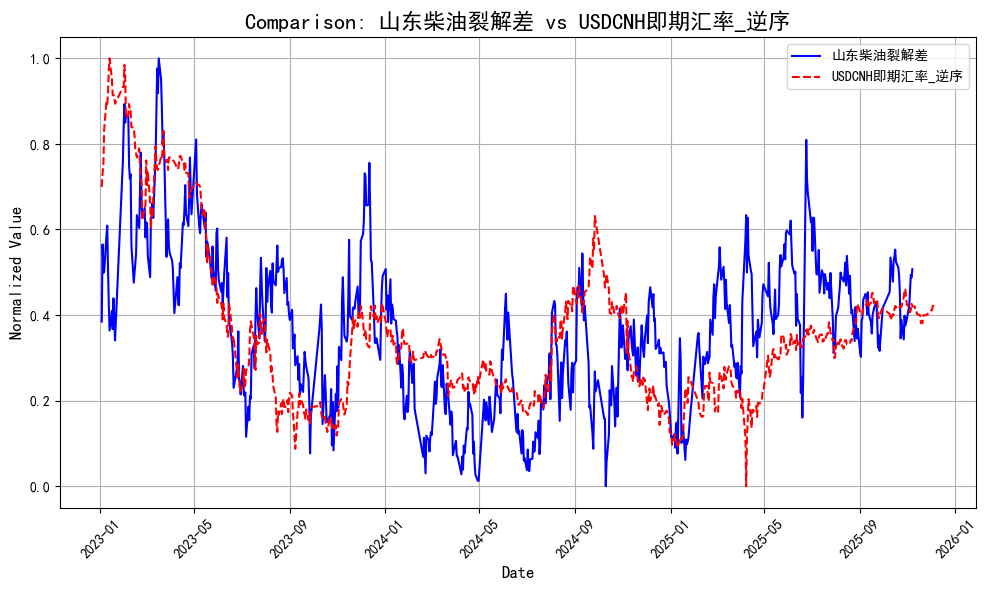

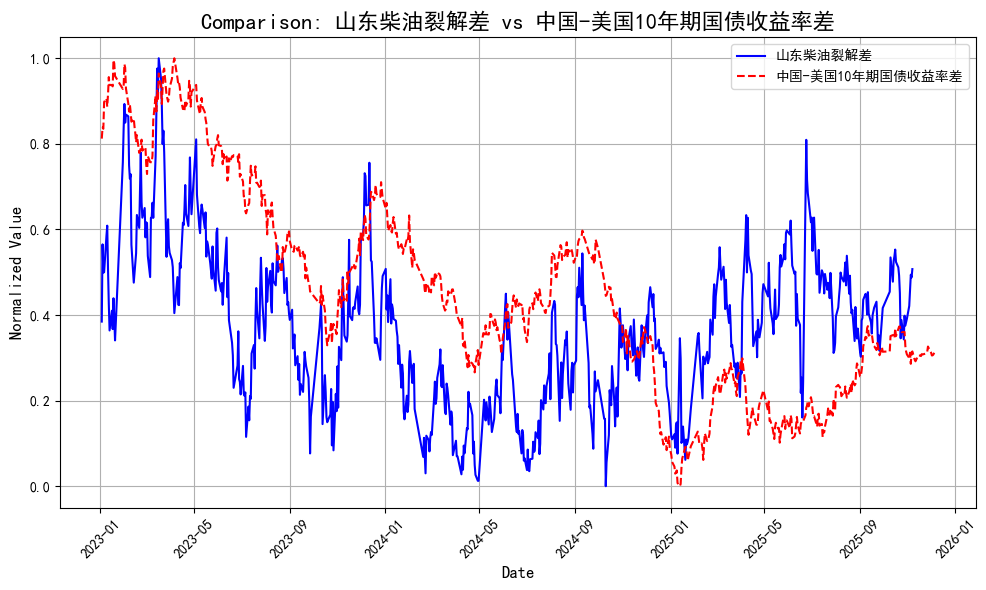

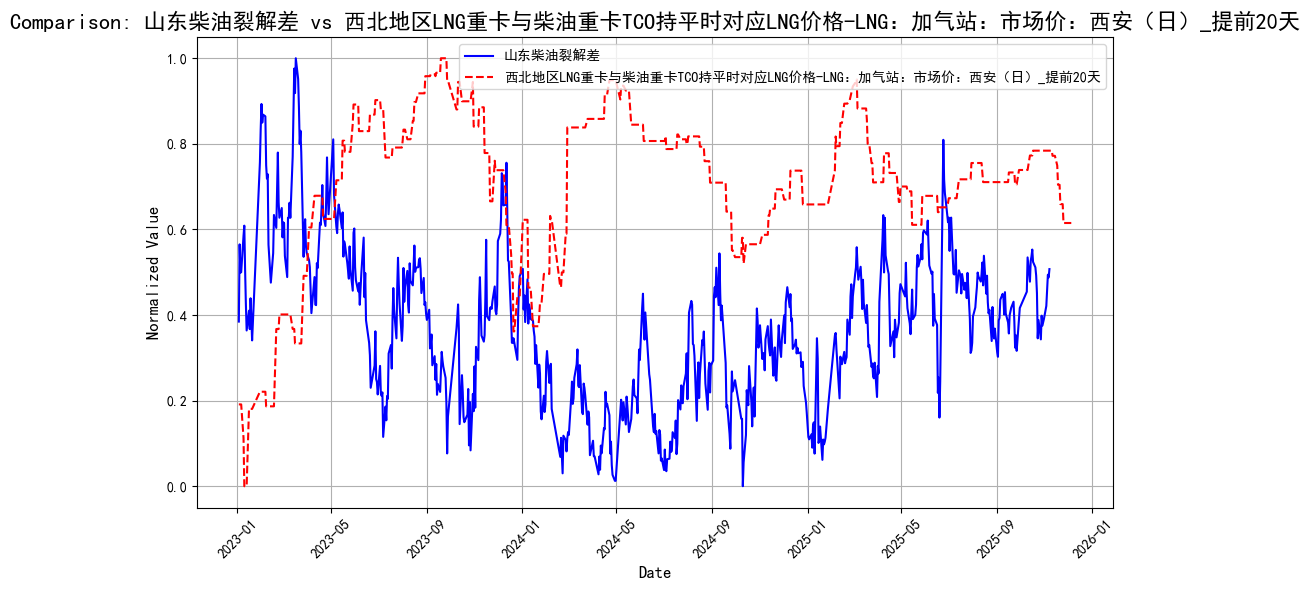

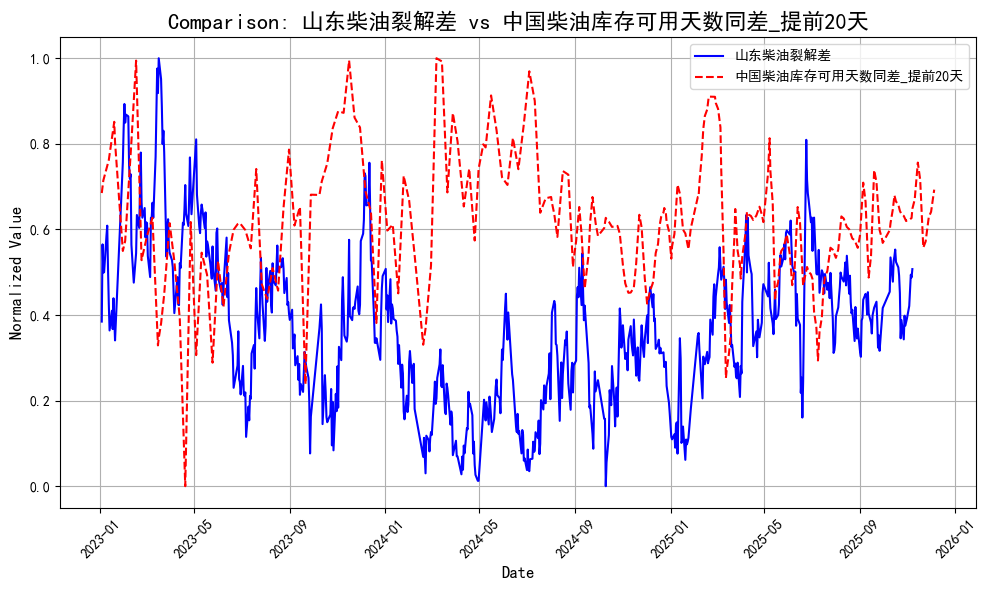

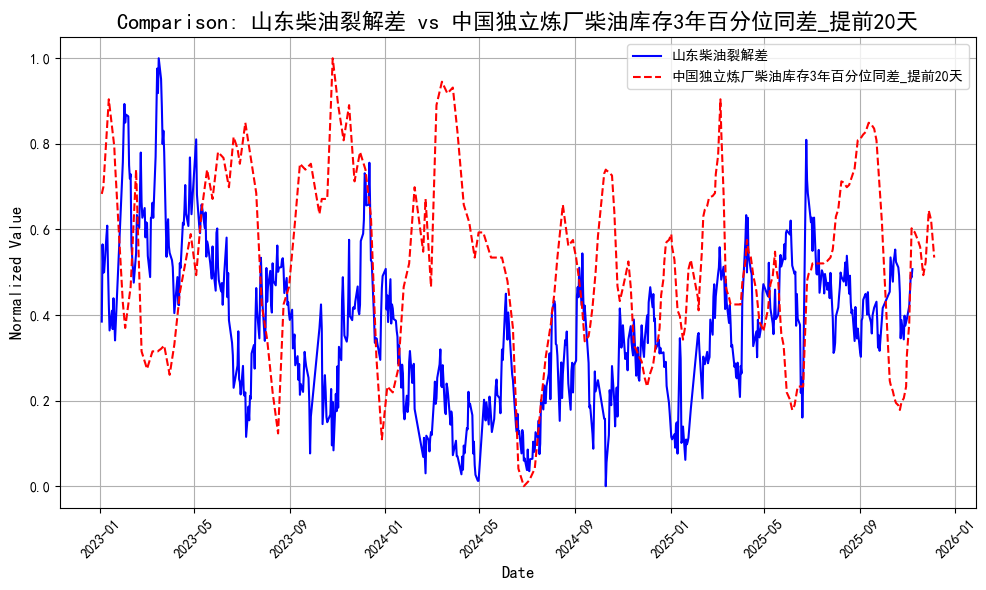

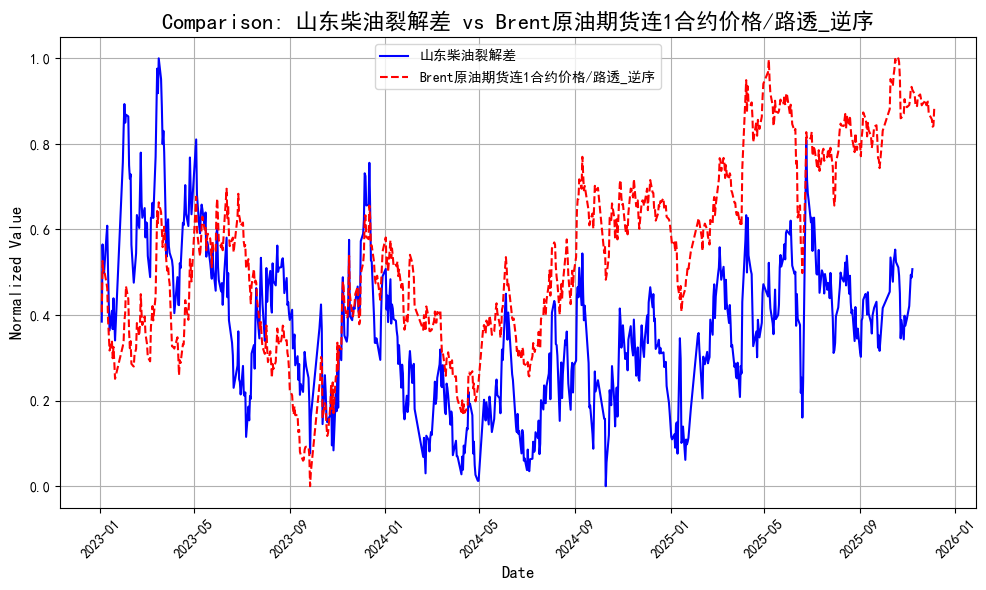

In [14]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='山东柴油裂解差', 
    compare_cols=[
        'WTI连1-20日环比_逆序',
        '柴油：社会库存：中国（周）：大样本4周环差_提前30天',
        '螺纹期货价格90日环比_提前30天',
        '0#柴油价差（华东-山东）_提前25天',
        '南华工业品指数20日环比_提前30天',
        '富时中国A50期货CN0W.SG收盘价5日环比/10DMA_提前20天',
        'DR007 - 7天逆回购利率/15DMA90日环差_提前25天',
        '柴油：独立炼厂：产量：中国（周）超季节性/3年_提前20天_逆序',
        'USDCNH即期汇率_逆序',
        '中国-美国10年期国债收益率差',
        '西北地区LNG重卡与柴油重卡TCO持平时对应LNG价格-LNG：加气站：市场价：西安（日）_提前20天',
        '中国柴油库存可用天数同差_提前20天',
        '中国独立炼厂柴油库存3年百分位同差_提前20天',
        'Brent原油期货连1合约价格/路透_逆序'
        ]
)

In [15]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 20
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        'WTI连1-20日环比_逆序',
        'WTI连1-20日环比_逆序_提前1天',
        'WTI连1-20日环比_逆序_提前2天',
        'WTI连1-20日环比_逆序_提前3天',
        'WTI连1-20日环比_逆序_提前4天',
        'WTI连1-20日环比_逆序_提前5天',
        'WTI连1-20日环比_逆序_提前6天',
        'WTI连1-20日环比_逆序_提前7天',
        '柴油：社会库存：中国（周）：大样本4周环差_提前30天',
        '螺纹期货价格90日环比_提前30天',
        '0#柴油价差（华东-山东）_提前25天',
        '南华工业品指数20日环比_提前30天',
        '富时中国A50期货CN0W.SG收盘价5日环比/10DMA_提前20天',
        'DR007 - 7天逆回购利率/15DMA90日环差_提前25天',
        '柴油：独立炼厂：产量：中国（周）超季节性/3年_提前20天_逆序',
        'USDCNH即期汇率_逆序',
        '中国-美国10年期国债收益率差',
        '西北地区LNG重卡与柴油重卡TCO持平时对应LNG价格-LNG：加气站：市场价：西安（日）_提前20天',
        '中国柴油库存可用天数同差_提前20天',
        '中国独立炼厂柴油库存3年百分位同差_提前20天',
        'Brent原油期货连1合约价格/路透_逆序'
]

predict_column = '山东柴油裂解差'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.05, 
    'max_depth': 8, 
    'min_child_weight': 0.6, 
    'subsample': 0.5, 
    'colsample_bytree': 0.4, 
    'gamma': 0.260359403556242, 
    'reg_alpha': 0.8, 
    'reg_lambda': 0.7,
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
#    'max_delta_step': 5,
#    'tree_method': 'auto'
}



num_boost_round = 2000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:133.56365	train-rmse:209.88826


[500]	eval-rmse:47.12937	train-rmse:0.71751


[1000]	eval-rmse:47.06148	train-rmse:0.31855


[1500]	eval-rmse:47.08155	train-rmse:0.29674


[1999]	eval-rmse:47.07873	train-rmse:0.28475


训练集 MSE (DMatrix): 0.0898, 训练集 R² (DMatrix): 1.0
测试集 MSE (DMatrix): 2216.4068, 测试集 R² (DMatrix): 0.6705


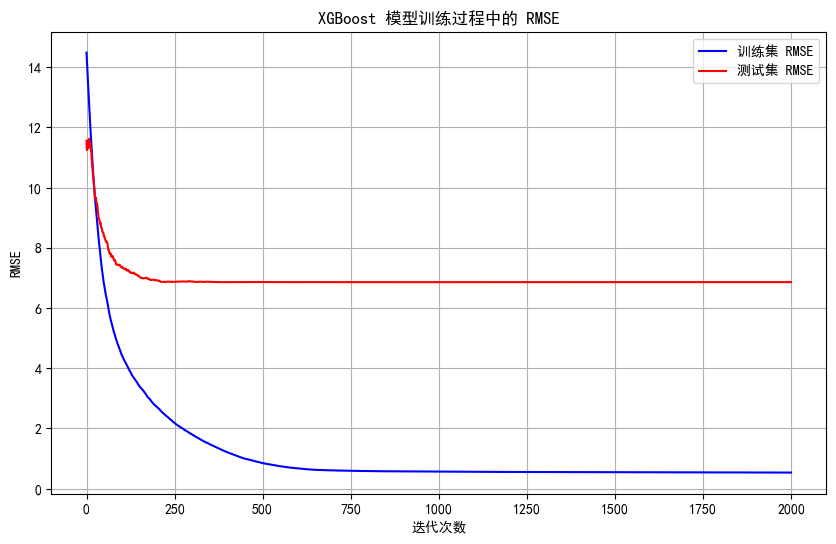

In [16]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:207.93747


[500]	train-rmse:0.73967


[1000]	train-rmse:0.31525


[1500]	train-rmse:0.29483


[1999]	train-rmse:0.28480


全部数据 MSE: 0.0884, 全部数据 R²: 1.0


Gap between last actual value and first prediction: 32.4888674804688


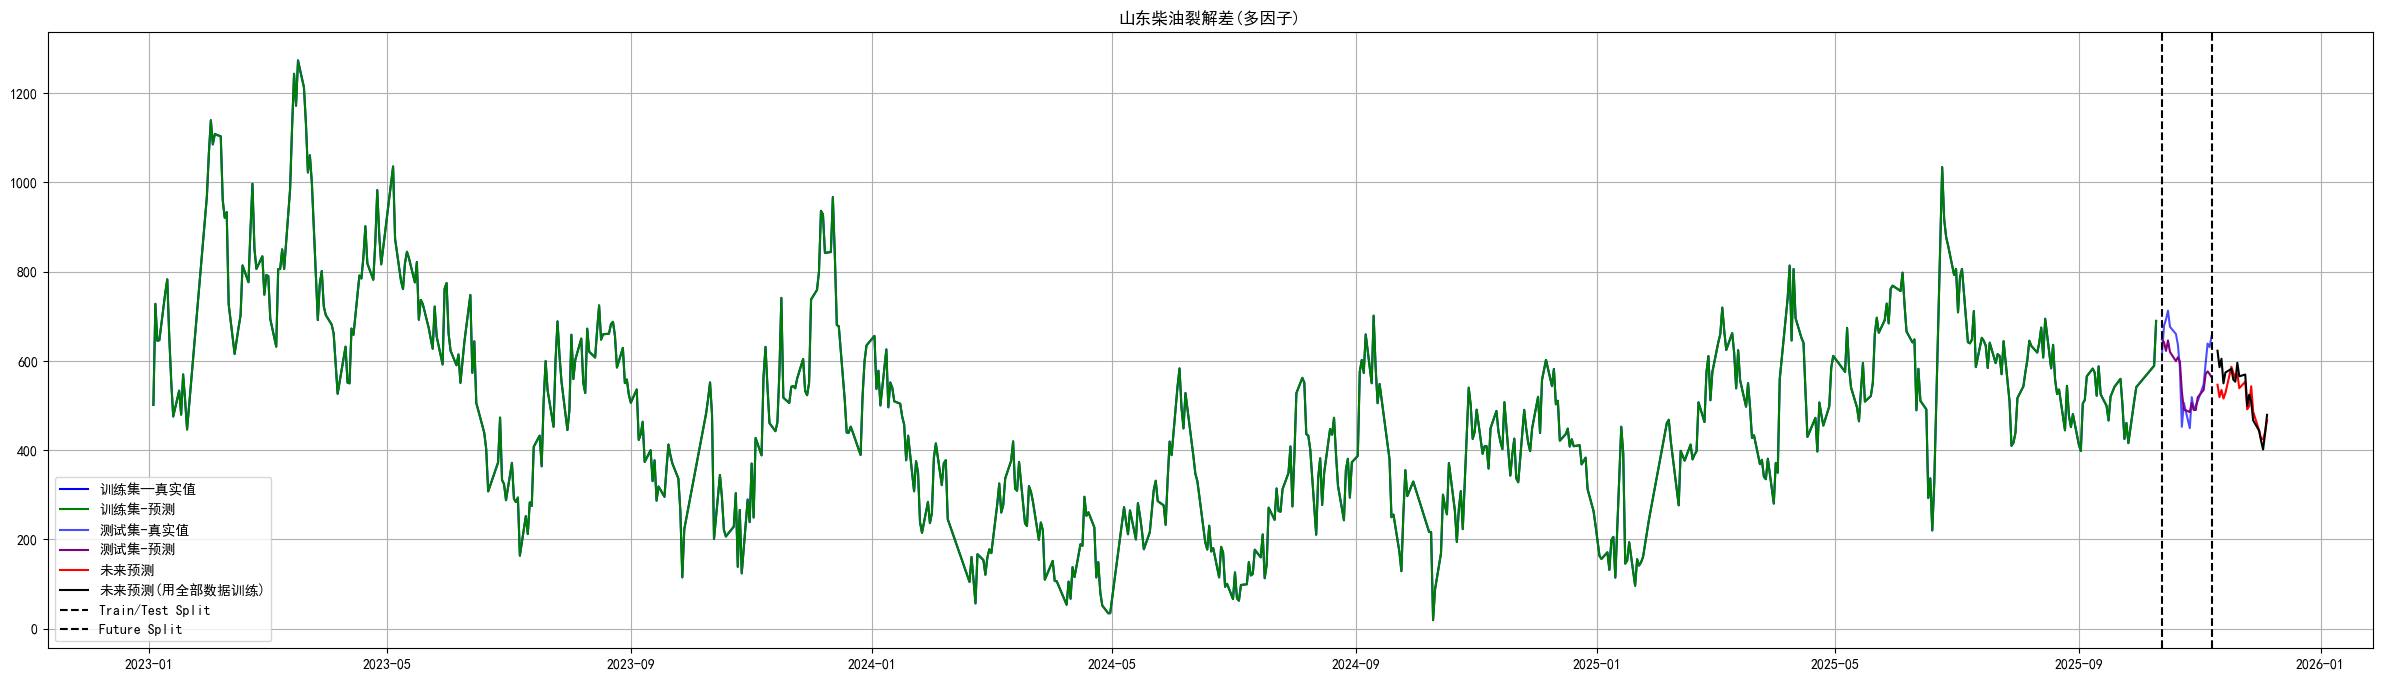

In [18]:
# 定义函数计算差值并调整预测值

plt.figure(figsize=(30, 8))
# 绘制主要数据
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('山东柴油裂解差(多因子)')
plt.legend()
plt.grid(True)
plt.show()

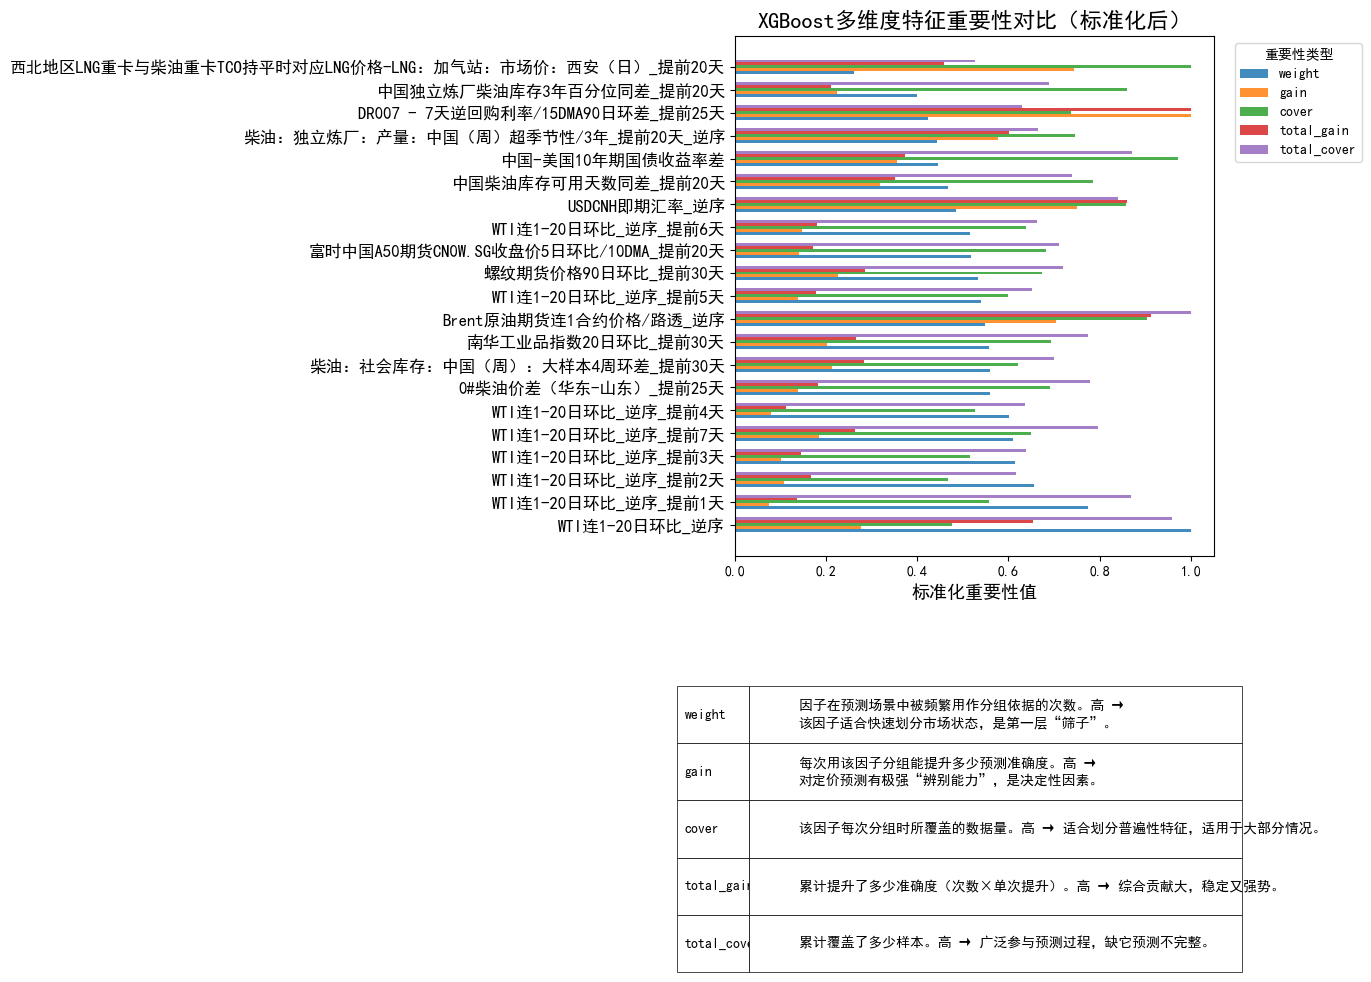

,weight,gain,cover,total_gain,total_cover
WTI连1-20日环比_逆序,1.000000,0.277169,0.477111,0.653834,0.959792
WTI连1-20日环比_逆序_提前1天,0.774224,0.074167,0.557199,0.135456,0.867830
WTI连1-20日环比_逆序_提前2天,0.656211,0.107462,0.467478,0.166350,0.617111
WTI连1-20日环比_逆序_提前3天,0.613975,0.100837,0.516579,0.146047,0.638036
WTI连1-20日环比_逆序_提前7天,0.609938,0.183852,0.649840,0.264531,0.797351
WTI连1-20日环比_逆序_提前4天,0.600932,0.078562,0.525687,0.111368,0.635492
0#柴油价差（华东-山东）_提前25天,0.560248,0.137580,0.690779,0.181827,0.778534
柴油：社会库存：中国（周）：大样本4周环差_提前30天,0.559938,0.213941,0.620865,0.282591,0.699351
南华工业品指数20日环比_提前30天,0.556522,0.201890,0.692525,0.265045,0.775310
Brent原油期货连1合约价格/路透_逆序,0.549379,0.704177,0.904837,0.912592,1.000000


In [19]:

#绘制因子重要性
plot_xgb_feature_importance(model_all, X_train)



---

In [20]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/山东柴油裂解差(多因子)_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily.head() 

,Date,真实值,预测值
703,2025/12/05,NaN,479.206116
702,2025/12/04,NaN,436.961182
701,2025/12/03,NaN,401.426880
700,2025/12/02,NaN,421.062927
699,2025/12/01,NaN,443.630371


In [21]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/山东柴油裂解差(多因子)_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly.head()

,Date,真实值,预测值
35,2025/12/31,NaN,436.457520
34,2025/11/30,613.482440,558.866150
33,2025/10/31,586.285776,575.097656
32,2025/09/30,507.309677,507.352325
31,2025/08/31,570.939843,570.929199


---

In [22]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "山东柴油裂解差(多因子)"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [23]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "山东柴油裂解差(多因子)"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
